# 

# Building an OCR from scratch

So in this tutorial, I will give you a basic code walkthrough for building a simple OCR. OCR as might know stands for optical character recognition or in layman terms it means text recognition. Text recognition is one of the classic problems in computer vision and is still relevant today. One of the most important applications of text recognition is the digitization of old manuscripts. Physical copies of books and manuscripts are prone to degradations. With time, the printed characters start to fade. On simple way to preserve such documents is to make a digital copy of it and store it in the cloud or local hard drive which would ensure their continuance. Similarly, text recognition can also be used for licence plate recognition and can also be used in forensics in terms of handwriting recognition. 

Okay, now that I have given you enough motivation as to why OCR is important, let me show you how you can build one. 
So first things first, I'll start with listing down some of the essential packages that you would need to build your first OCR. We will be working with PyTorch as it is one of the most efficient deep learning libraries present. The other packages are as follows:

* Pytorch 1.5
* Matplotlib
* Tqdm
* textdistance
* lmdb

You can install them either via a pip or conda. I will also be providing a requirements.txt file which you can find in my Github repo. Do a simple `pip install -r requirements` and you are set to go.

## Setting up the Data

We will start our project by importing the libraries. But before that we need data. Now, you are free to use any text image data you might like and for that, you might need to build your own data loader. However, in the interest of keeping things simple, we will be using a neat little package called `trdg`, which is a synthetic image generator for OCR. You can find all the relevant information regarding this package on its [github repository](https://github.com/Belval/TextRecognitionDataGenerator). You can generate printed as well as hand-written text images and infuse them with different kinds of noise and degradation. In this project, I have used trdg to generate printed word images of a single font. You can use any font you like. Just download a `.ttf` file for your font and while generating the word images be sure to specify the `-ft` parameter as your font file. 

You can generate the word images for training using the following commands:

`trdg -i words.txt -c 20000 --output_dir data/train -ft your/fontfile`

ATENTION: Run this one instead `trdg -i words.txt -c 20000 --output_dir data/train -fd fonts/`

Here, `-c` refers to the number of word images you want to generate. `words.txt` file contains our input word vocabulary while `--output_dir` and `-ft` refer to the output and font file respectively. You can similarly generate the test word images for evaluating the performance of your OCR. However, ensure that words for training and testing are mutually exclusive to each other.

Okay, now that we have generated the word images, let us display a few images using matlplotlib
%# TODO diplay images from folder

Now lets start importing the libraries that we would need to build our OCR

In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *

# added
import xmltodict

In [2]:
!conda info


     active environment : None
       user config file : /home/guscarrian@GU.GU.SE/.condarc
 populated config files : 
          conda version : 4.12.0
    conda-build version : not installed
         python version : 3.9.7.final.0
       virtual packages : __cuda=12.2=0
                          __linux=6.4.11=0
                          __glibc=2.37=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /usr/local/miniconda3  (read only)
      conda av data dir : /usr/local/miniconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /usr/local/miniconda3/pkgs
                          /home/guscarrian@GU.GU.SE/.conda/pkgs
       envs directo

Next, let us create our data pipe-line. We do this by inheriting the PyTorch Dataset class. The Dataset class has few methods that we need to adhere to like the `__len__` and `__getitem__` method. The `__len__` method returns the number of items in our dataset while `__getitem_` returns the data item for the index passed. You can find more information on PyTorch Dataset class on PyTorch's official documentation page. 

You will observe that we first convert each image into grayscale and convert it into a tensor. This is followed by normalizing the images so that our input data lies within a range of [-1, 1]. We pass all such transformations into a list and later call the transforms to compose function provided by PyTorch. The transform Compose function applies each transformation in the pre-defined order.

In [23]:
# Directories where the car plates images and annotations are stored:
img_dir = '/home/guscarrian@GU.GU.SE/LT2326-ML/A1/Adapting-OCR/carplates_dataset/LP-characters/images'
ann_dir = '/home/guscarrian@GU.GU.SE/LT2326-ML/A1/Adapting-OCR/carplates_dataset/LP-characters/annotations'

# Using os.listdir to get the lists of the image and annotation files:
img_files = sorted(os.listdir(img_dir))
ann_files = sorted(os.listdir(ann_dir))

# Creating full paths with os.path.join:
images = [os.path.join(img_dir, file) for file in img_files]
annotations = [os.path.join(ann_dir, file) for file in ann_files]

In [9]:
# Dividing the car plates dataset into training (80%) and test (20%) sets:
images_train, images_test, annotations_train, annotations_test = train_test_split(images, annotations, test_size=0.2, random_state=42)

# Creating a CarPlatesDataset object for the training and test sets:
train_dataset = CarPlatesDataset(images_train, annotations_train, transform=...)
test_dataset = CarPlatesDataset(images_test, annotations_test, transform=...)

In [2]:
dataset_original.__getitem__(1)

NameError: name 'dataset_original' is not defined

In [2]:
# New dataloader - CarPlatesDataset
# Both __init__ and __len__ methods remain the same
class CarPlatesDataset(Dataset):
    
    def __init__(self, opt):
        super(CarPlatesDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.images = os.listdir(self.path)
        self.annotations_dir = os.path.join(opt['path'], opt['annotations_dir']) #added
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
       	transform_list =  [transforms.Grayscale(1),
                           #transforms.Resize(self.image_size), #added
                           transforms.Resize((opt['image_size'][0], opt['image_size'][1])), #added
                           #transforms.Resize((opt['H'], opt['W'])),
                           transforms.ToTensor(), 
                           transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        imagefile = imagefile.split('.')[0]

        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)

        # 'annotations' is the path to the XML files. 
        # We open the file, read it and convert the data into a dictionary.
        # Then we go through each 'object' in the xml data, extract the 'name' field, and add it to a list (labels). 
        # We combine the labels from the list into a single string and, finally, return a dictionary with the image, index, and label.
        annotations = os.path.join(self.annotations_dir, imagefile + '.xml')
        labels = []
        try:
            with open(annotations, 'r') as file:
                data_dict = xmltodict.parse(file.read())
            for item in data_dict['annotation']['object']:
                name = item['name']
                labels.append(name)
        except (xmltodict.expat.ExpatError, FileNotFoundError):
            print(f"Error while parsing {annotations}.")

        label = ''.join(labels)
        
        item = {'img': img, 'idx': index, 'label': label}
        return item

In [6]:
dataset = CarPlatesDataset(args)

In [7]:
dataset.__getitem__(1)

{'img': tensor([[[-0.0431, -0.0824, -0.1686,  ..., -0.8902, -0.8980, -0.8980],
          [-0.0431, -0.0353, -0.0275,  ..., -0.7961, -0.7569, -0.7098],
          [-0.1294, -0.1059, -0.1059,  ..., -0.1765, -0.1529, -0.1294],
          ...,
          [-0.9686, -0.9765, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9608, -0.9608, -0.9686],
          [-0.9608, -0.9686, -0.9686,  ..., -0.9608, -0.9608, -0.9765]]]),
 'idx': 1,
 'label': 'MH2OBN3525'}

In [9]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp1',
    'path':'/home/guscarrian@GU.GU.SE/LT2326-ML/A1/Adapting-OCR/carplates_dataset/LP-characters',
    'imgdir': 'train_images',
    'annotations_dir': 'annotations',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':4,
    'batch_size':32,
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':False,
    'schedule':False
}

Next, since we are going to train our model using the mini-batch gradient descent, it is essential that each image in the batch is of the same shape and size. For this, we have defined the `SynthCollator` class which initially finds the image with maximum width in the batch and then proceeds to pad all images to have the same width. 

In [3]:
class SynthCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

## Defining our Model

Now we proceed to define our model. We use the CNN-LSTM based architecture which was proposed by Shi et.al. in their excellent paper [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf). The authors used it for scene-text recognition and showed via extensive experimentation that they were able to achieve significant gains in accuracy compared to all other existing methods at that time.


<img src="images/crnn.png" alt="drawing" width="400"/>

The figure above shows the architecture used in the paper. The authors used a 7 layered Convolution network with BatchNorm and ReLU. This was followed by a stacked RNN network consisting of two Bidirectional LSTM layers. The convolution layers acted as a feature extractor while the LSTMs layers act as sequence classifiers. The LSTM layers output the probability associated with each output class at each time step
Further details can be found in their paper and I strongly suggest you go through it for a better understanding.

The below code snippet is taken from this [github repository](https://github.com/meijieru/crnn.pytorch) which provides a Pytorch implementation of their code.


In [4]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

## The CTC Loss 

Okay, now that we have our data and model pipeline ready, it is time to define our loss function which in our case is the CTC loss function. We will be using PyTorch's excellent CTC implementation. CTC stands for Connectionist Temporal Classification and was proposed by Alex Graves in his paper [Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks](https://www.cs.toronto.edu/~graves/icml_2006.pdf). 

Honestly, the above work has been a gamechanger for many sequences based tasks like speech and text recognition. For all the sequence-based tasks it is important for the input and output labels to be properly aligned. Proper alignment leads to efficient loss computation between the network predictions and expected output. In segmentation based approaches i.e. when the input word or line has been segmented into its constituent characters, there exists a direct one-to-one mapping between the segmented images of characters and the output labels.  However, as you might imagine obtaining such segmentations for each character can be a very tedious and time-consuming task. Thus, CTC based transcription layers have become the de-facto choice for OCRs and speech recognition module since it allows loss computation without explicit mapping between the input and output. The CTC layer takes the output from the LSTMs and computes a score with all possible alignments of the target label. The OCR is then trained to predict a sequence which maximizes the sum of all such scores.

If you want more thorough details regarding the CTC layer I would suggest you go through the following blogs and lecture video

* [CMU Deep Learning Course Lecture 14](https://www.youtube.com/watch?v=c86gfVGcvh4&t=670s)
* [Sequence Labelling with CTC](https://distill.pub/2017/ctc)

In [5]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

## The Training Loop

The above code snippet builds a wrapper around pytorch's CTC loss function. Basically, what it does is that it computes the loss and passes it through an additional method called `debug`, which checks for instances when the loss becomes Nan. 

Shout out to [Jerin Philip](https://jerinphilip.github.io/) for this code.

Now, let us come to the training loop. The below code might look a bit cumbersome but it provides a nice abstraction which is quite intuitive and easy to use. The below code is based on [pytorch lighning](https://github.com/PyTorchLightning/pytorch-lightning)'s bolier plate template with few modifications of my own. :P

I will give a basic overview of what it does. Feel free to inspect each method using python debugger. So, the `OCRTrainer` class takes in the training and validation data. It also takes in the loss function, optimizer and the number of epoch it needs to train the model. The train and validation loader method returns the data loader for the train and validation data. the `run_batch` method does one forward pass for a batch of image-label pairs. It returns the loss as well as the character and word accuracy. Next, we have the step functions which does the backpropagation, calculates the gradient and updates the parameters for each batch of data. Besides we also have the `training_end` and `validation_end` methods that calculate the mean loss and accuracy for each batch after the completion of one single epoch

All, the methods defined are quite simple and I hope you will get the hang of it in no time.

In [6]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

## Putting Everything Together

And, finally, we have the `Learner` class. It implements a couple of more methods like the `save` and `load` model. It also tracks the losses and saves them in a `csv` file. This comes in handy if we want to analyze the behaviour of our training and validation loops. It initializes our `OCRTrainer` module with the necessary hyperparameters and later calls the `fit` method which runs the training loop.

Besides these methods, we have a bunch of helper methods like the `OCRLabel_converter`, `Eval` and `Averagemeter`. I am not including them in this notebook, instead, I have written them in utils.py file and I am importing them from there. In case you want to take a peek, feel free to tinker with the utils.py file. All the necessary documentation is provided in the file itself.

In [7]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        #self.model.load_state_dict(self.checkpoint['state_dict'])
        self.model.load_state_dict(self.checkpoint['state_dict'], strict=False)
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            #self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'], strict=False)

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

### Defining the hyperparameters

Okay, now that we have set the premise, its time to unfold the drama. We begin by defining our vocabulary i.e. the alphabets which serve as the output classes for our model.
We define a suitable name for this experiment which will also serve as the folder name where the checkpoints and log files will be stored. We also define the hyper-parameters like the batch size, learning rate, image height, number of channels etc.

Then we initialize our Dataset class and split the data into train and validation. We then proceed to initialize our Model and CTCLoss and finally call the `learner.fit` function.

Once the training is over we can find the saved model in the `checkpoints/name` folder. We may load the model and evaluate its performance on the test data or finetune it on some other data.

In [13]:
%env CUDA_VISIBLE_DEVICE = 3

env: CUDA_VISIBLE_DEVICE=3


In [14]:
print(torch.cuda.current_device())

0


In [16]:
torch.cuda.current_device()

0

In [17]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [ ]:
# original alphabet and args:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp1',
    'path':'../data',
    'imgdir': 'train',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':4,
    'batch_size':32,
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':False,
    'schedule':False
    
}

In [9]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp1',
    'path':'/home/guscarrian@GU.GU.SE/LT2326-ML/A1/Adapting-OCR/carplates_dataset/LP-characters',
    'imgdir': 'train_images',
    'annotations_dir': 'annotations',
    'image_size': (32, 168), #added
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':150,
    'batch_size':128,
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':False,
    'schedule':False
}

data = CarPlatesDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:133
Val Data Size:34
Let's use 4 GPUs!
checkpoint does not exist
None
Scheduling is False


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.05it/s, val_loss=16.2, val_ca=0, val_wa=0]


16.17490577697754
Validation loss decreased (inf --> 16.174906).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.23it/s, val_loss=4.65, val_ca=0, val_wa=0]


10.414025783538818
Validation loss decreased (16.174906 --> 10.414026).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  4.03it/s, val_loss=3.88, val_ca=0, val_wa=0]


8.237610340118408
Validation loss decreased (10.414026 --> 8.237610).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.38it/s, val_loss=3.62, val_ca=0, val_wa=0]


7.083249151706696
Validation loss decreased (8.237610 --> 7.083249).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.51it/s, val_loss=3.65, val_ca=0, val_wa=0]


6.395938539505005
Validation loss decreased (7.083249 --> 6.395939).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.13it/s, val_loss=3.48, val_ca=0, val_wa=0]


5.909117738405864
Validation loss decreased (6.395939 --> 5.909118).  Saving model ...


Validating: 100%|████████████████████| 1/1 [00:00<00:00,  3.42it/s, val_loss=3.5, val_ca=0, val_wa=0]


5.564677681241717
Validation loss decreased (5.909118 --> 5.564678).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  3.08it/s, val_loss=3.47, val_ca=0, val_wa=0]


5.302781522274017
Validation loss decreased (5.564678 --> 5.302782).  Saving model ...


Validating: 100%|████████████████████| 1/1 [00:00<00:00,  3.09it/s, val_loss=3.5, val_ca=0, val_wa=0]


5.102954493628608
Validation loss decreased (5.302782 --> 5.102954).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  3.05it/s, val_loss=3.47, val_ca=0, val_wa=0]


4.940143203735351
Validation loss decreased (5.102954 --> 4.940143).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  2.94it/s, val_loss=3.42, val_ca=0, val_wa=0]


4.8020563992587
Validation loss decreased (4.940143 --> 4.802056).  Saving model ...


Validating: 100%|████████████████████| 1/1 [00:00<00:00,  2.90it/s, val_loss=3.4, val_ca=0, val_wa=0]


4.685556451479594
Validation loss decreased (4.802056 --> 4.685556).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  2.94it/s, val_loss=3.39, val_ca=0, val_wa=0]


4.58592623930711
Validation loss decreased (4.685556 --> 4.585926).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  2.88it/s, val_loss=3.39, val_ca=0, val_wa=0]


4.500537395477295
Validation loss decreased (4.585926 --> 4.500537).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  2.69it/s, val_loss=3.38, val_ca=0, val_wa=0]


4.425675789515178
Validation loss decreased (4.500537 --> 4.425676).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  3.12it/s, val_loss=3.37, val_ca=0, val_wa=0]


4.359540328383446
Validation loss decreased (4.425676 --> 4.359540).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  2.98it/s, val_loss=3.35, val_ca=0, val_wa=0]


4.299879102145924
Validation loss decreased (4.359540 --> 4.299879).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:01<00:00,  1.26s/it, val_loss=3.31, val_ca=0, val_wa=0]


4.244879656367832
Validation loss decreased (4.299879 --> 4.244880).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.12it/s, val_loss=3.29, val_ca=0, val_wa=0]


4.19487086095308
Validation loss decreased (4.244880 --> 4.194871).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.30it/s, val_loss=3.27, val_ca=0, val_wa=0]


4.148607099056244
Validation loss decreased (4.194871 --> 4.148607).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  4.93it/s, val_loss=3.25, val_ca=0, val_wa=0]


4.105870882670085
Validation loss decreased (4.148607 --> 4.105871).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.72it/s, val_loss=3.23, val_ca=0, val_wa=0]


4.0662678480148315
Validation loss decreased (4.105871 --> 4.066268).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.96it/s, val_loss=3.21, val_ca=0, val_wa=0]


4.029252663902614
Validation loss decreased (4.066268 --> 4.029253).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.82it/s, val_loss=3.19, val_ca=0, val_wa=0]


3.9944714109102883
Validation loss decreased (4.029253 --> 3.994471).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  5.10it/s, val_loss=3.18, val_ca=0, val_wa=0]


3.9619878578186034
Validation loss decreased (3.994471 --> 3.961988).  Saving model ...


Epoch: [24]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.90it/s, loss=3.04, train_ca=6.22, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.31it/s, val_loss=3.15, val_ca=3.71, val_wa=0]


3.930678129196167
Validation loss decreased (3.961988 --> 3.930678).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.72it/s, val_loss=3.13, val_ca=4.63, val_wa=0]


3.901015449453283
Validation loss decreased (3.930678 --> 3.901015).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.03it/s, val_loss=3.13, val_ca=4.77, val_wa=0]


3.8735105991363525
Validation loss decreased (3.901015 --> 3.873511).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.99it/s, val_loss=3.14, val_ca=4.77, val_wa=0]


3.8483552603886046
Validation loss decreased (3.873511 --> 3.848355).  Saving model ...


Epoch: [28]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.81it/s, loss=3.09, train_ca=8.22, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.80it/s, val_loss=3.11, val_ca=4.77, val_wa=0]


3.8238170464833576
Validation loss decreased (3.848355 --> 3.823817).  Saving model ...


Epoch: [29]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.74it/s, loss=3.25, train_ca=3.43, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.85it/s, val_loss=3.09, val_ca=4.77, val_wa=0]


3.8002733492082164
Validation loss decreased (3.823817 --> 3.800273).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.65it/s, val_loss=3.07, val_ca=4.92, val_wa=0]


3.777435265481472
Validation loss decreased (3.800273 --> 3.777435).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.01it/s, val_loss=3.06, val_ca=6.66, val_wa=0]


3.755648136138916
Validation loss decreased (3.777435 --> 3.755648).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.83it/s, val_loss=3.05, val_ca=6.66, val_wa=0]


3.7349768175798306
Validation loss decreased (3.755648 --> 3.734977).  Saving model ...


Validating: 100%|█████████████████| 1/1 [00:00<00:00,  2.85it/s, val_loss=3.05, val_ca=5.1, val_wa=0]


3.7154489517211915
Validation loss decreased (3.734977 --> 3.715449).  Saving model ...


Epoch: [34]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.66it/s, loss=2.87, train_ca=4.22, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.74it/s, val_loss=3.06, val_ca=5.61, val_wa=0]


3.6973309450679355
Validation loss decreased (3.715449 --> 3.697331).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.73it/s, val_loss=3.07, val_ca=5.61, val_wa=0]


3.680414193385356
Validation loss decreased (3.697331 --> 3.680414).  Saving model ...


Epoch: [36]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.96it/s, loss=2.83, train_ca=12.7, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.51it/s, val_loss=3.06, val_ca=6.66, val_wa=0]


3.664174619473909
Validation loss decreased (3.680414 --> 3.664175).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.12it/s, val_loss=3.03, val_ca=6.66, val_wa=0]


3.648022009776189
Validation loss decreased (3.664175 --> 3.648022).  Saving model ...


Epoch: [38]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.92it/s, loss=3.63, train_ca=3.43, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.78it/s, val_loss=3.03, val_ca=6.66, val_wa=0]


3.632508486509323
Validation loss decreased (3.648022 --> 3.632508).  Saving model ...


Epoch: [39]/[150] Training: 100%|█| 2/2 [00:00<00:00,  3.28it/s, loss=2.91, train_ca=4.22, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.28it/s, val_loss=3.03, val_ca=6.66, val_wa=0]


3.617912275035207
Validation loss decreased (3.632508 --> 3.617912).  Saving model ...


Epoch: [40]/[150] Training: 100%|█| 2/2 [00:00<00:00,  3.15it/s, loss=2.74, train_ca=10.7, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.48it/s, val_loss=2.99, val_ca=5.61, val_wa=0]


3.602858060882205
Validation loss decreased (3.617912 --> 3.602858).  Saving model ...


Epoch: [41]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.98it/s, loss=2.98, train_ca=8.22, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.56it/s, val_loss=2.99, val_ca=6.66, val_wa=0]


3.588514899098596
Validation loss decreased (3.602858 --> 3.588515).  Saving model ...


Validating: 100%|███████████████████| 1/1 [00:00<00:00,  3.20it/s, val_loss=3, val_ca=6.66, val_wa=0]


3.5750660733743147
Validation loss decreased (3.588515 --> 3.575066).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.84it/s, val_loss=3.03, val_ca=6.66, val_wa=0]


3.563023567199707
Validation loss decreased (3.575066 --> 3.563024).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.45it/s, val_loss=2.96, val_ca=4.77, val_wa=0]


3.549999107485232
Validation loss decreased (3.563024 --> 3.549999).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.01it/s, val_loss=2.94, val_ca=5.61, val_wa=0]


3.5370279626643404
Validation loss decreased (3.549999 --> 3.537028).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.30it/s, val_loss=3.02, val_ca=6.66, val_wa=0]


3.5262468506892524
Validation loss decreased (3.537028 --> 3.526247).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.24it/s, val_loss=3.16, val_ca=6.66, val_wa=0]


3.5187501907348633
Validation loss decreased (3.526247 --> 3.518750).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.67it/s, val_loss=2.95, val_ca=6.98, val_wa=0]


3.507303228378296
Validation loss decreased (3.518750 --> 3.507303).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.82it/s, val_loss=2.92, val_ca=7.37, val_wa=0]


3.4958021033043956
Validation loss decreased (3.507303 --> 3.495802).  Saving model ...


Epoch: [50]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.84it/s, loss=2.66, train_ca=4.22, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.96it/s, val_loss=3.02, val_ca=6.11, val_wa=0]


3.4866402653547435
Validation loss decreased (3.495802 --> 3.486640).  Saving model ...


Epoch: [51]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.92it/s, loss=2.82, train_ca=1.82, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.93it/s, val_loss=2.92, val_ca=6.11, val_wa=0]


3.475982908932668
Validation loss decreased (3.486640 --> 3.475983).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=2.91, val_ca=6.66, val_wa=0]


3.465414462266145
Validation loss decreased (3.475983 --> 3.465414).  Saving model ...


Epoch: [53]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.65it/s, loss=2.89, train_ca=14.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.67it/s, val_loss=2.89, val_ca=6.66, val_wa=0]


3.454999897696755
Validation loss decreased (3.465414 --> 3.455000).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.84it/s, val_loss=2.87, val_ca=13.9, val_wa=0]


3.4445013276168277
Validation loss decreased (3.455000 --> 3.444501).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.55it/s, val_loss=2.87, val_ca=13.9, val_wa=0]


3.4343795190777695
Validation loss decreased (3.444501 --> 3.434380).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.75it/s, val_loss=2.86, val_ca=13.9, val_wa=0]


3.4245475119557875
Validation loss decreased (3.434380 --> 3.424548).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  4.89it/s, val_loss=2.86, val_ca=13.1, val_wa=0]


3.415022187313791
Validation loss decreased (3.424548 --> 3.415022).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.71it/s, val_loss=2.86, val_ca=13.9, val_wa=0]


3.40574400027593
Validation loss decreased (3.415022 --> 3.405744).  Saving model ...


Epoch: [59]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.70it/s, loss=2.88, train_ca=8.22, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.47it/s, val_loss=3.23, val_ca=12.5, val_wa=0]


3.402801302612805
Validation loss decreased (3.405744 --> 3.402801).  Saving model ...


Epoch: [60]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.60it/s, loss=2.56, train_ca=14.4, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.71it/s, val_loss=2.93, val_ca=12.9, val_wa=0]


3.3951534917277675
Validation loss decreased (3.402801 --> 3.395153).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.26it/s, val_loss=2.97, val_ca=11.4, val_wa=0]


3.3884836719149636
Validation loss decreased (3.395153 --> 3.388484).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.01it/s, val_loss=2.92, val_ca=11.5, val_wa=0]


3.3811375349760056
Validation loss decreased (3.388484 --> 3.381138).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.07it/s, val_loss=2.93, val_ca=11.5, val_wa=0]


3.3742132920485277
Validation loss decreased (3.381138 --> 3.374213).  Saving model ...


Epoch: [64]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.74it/s, loss=2.65, train_ca=14.4, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=2.93, val_ca=11.8, val_wa=0]


3.3674476363442163
Validation loss decreased (3.374213 --> 3.367448).  Saving model ...


Epoch: [65]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.87it/s, loss=3.17, train_ca=9.43, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.19it/s, val_loss=2.89, val_ca=13.9, val_wa=0]


3.360280962132696
Validation loss decreased (3.367448 --> 3.360281).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.12it/s, val_loss=2.94, val_ca=14.2, val_wa=0]


3.354083331192241
Validation loss decreased (3.360281 --> 3.354083).  Saving model ...


Epoch: [67]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.35it/s, loss=2.72, train_ca=12.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.71it/s, val_loss=2.88, val_ca=13.9, val_wa=0]


3.347271950348564
Validation loss decreased (3.354083 --> 3.347272).  Saving model ...


Epoch: [68]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.80it/s, loss=2.67, train_ca=11.9, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=2.85, val_ca=12.9, val_wa=0]


3.340203104700361
Validation loss decreased (3.347272 --> 3.340203).  Saving model ...


Epoch: [69]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.85it/s, loss=2.83, train_ca=16.5, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.00it/s, val_loss=2.85, val_ca=18.2, val_wa=0]


3.333289898617167
Validation loss decreased (3.340203 --> 3.333290).  Saving model ...


Epoch: [70]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.82it/s, loss=2.64, train_ca=20.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.96it/s, val_loss=2.85, val_ca=13.9, val_wa=0]


3.3265831304921045
Validation loss decreased (3.333290 --> 3.326583).  Saving model ...


Epoch: [71]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.79it/s, loss=2.65, train_ca=17.1, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.26it/s, val_loss=2.85, val_ca=13.9, val_wa=0]


3.320021384382901
Validation loss decreased (3.326583 --> 3.320021).  Saving model ...


Epoch: [72]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.74it/s, loss=2.61, train_ca=12.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.91it/s, val_loss=2.84, val_ca=13.9, val_wa=0]


3.3135127795709147
Validation loss decreased (3.320021 --> 3.313513).  Saving model ...


Epoch: [73]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.80it/s, loss=2.91, train_ca=19.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.26it/s, val_loss=2.84, val_ca=13.9, val_wa=0]


3.307150328954061
Validation loss decreased (3.313513 --> 3.307150).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.92it/s, val_loss=2.82, val_ca=13.9, val_wa=0]


3.3007334031556783
Validation loss decreased (3.307150 --> 3.300733).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.50it/s, val_loss=2.82, val_ca=13.9, val_wa=0]


3.2944666193677232
Validation loss decreased (3.300733 --> 3.294467).  Saving model ...


Epoch: [76]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.09it/s, loss=2.57, train_ca=10.4, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.74it/s, val_loss=2.83, val_ca=17.2, val_wa=0]


3.288455061423473
Validation loss decreased (3.294467 --> 3.288455).  Saving model ...


Epoch: [77]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.74it/s, loss=2.87, train_ca=10.9, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.76it/s, val_loss=2.84, val_ca=14.1, val_wa=0]


3.2828266711174687
Validation loss decreased (3.288455 --> 3.282827).  Saving model ...


Epoch: [78]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.59it/s, loss=2.65, train_ca=8.72, train_wa=0
Validating: 100%|██████████████████| 1/1 [00:00<00:00,  2.66it/s, val_loss=2.85, val_ca=16, val_wa=0]


3.2774577260017397
Validation loss decreased (3.282827 --> 3.277458).  Saving model ...


Epoch: [79]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.39it/s, loss=2.55, train_ca=16.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.78it/s, val_loss=2.85, val_ca=16.5, val_wa=0]


3.2721980942620172
Validation loss decreased (3.277458 --> 3.272198).  Saving model ...


Epoch: [80]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.68it/s, loss=2.81, train_ca=17.7, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.72it/s, val_loss=2.84, val_ca=15.1, val_wa=0]


3.2669618565861773
Validation loss decreased (3.272198 --> 3.266962).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.88it/s, val_loss=2.83, val_ca=14.5, val_wa=0]


3.26166904690754
Validation loss decreased (3.266962 --> 3.261669).  Saving model ...


Epoch: [82]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.66it/s, loss=2.68, train_ca=10.5, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.12it/s, val_loss=2.81, val_ca=13.9, val_wa=0]


3.256324129445212
Validation loss decreased (3.261669 --> 3.256324).  Saving model ...


Epoch: [83]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.34it/s, loss=2.66, train_ca=14.4, train_wa=0
Validating: 100%|█████████████████| 1/1 [00:00<00:00,  2.71it/s, val_loss=2.8, val_ca=14.8, val_wa=0]


3.2509043777690216
Validation loss decreased (3.256324 --> 3.250904).  Saving model ...


Epoch: [84]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.73it/s, loss=2.52, train_ca=16.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.05it/s, val_loss=2.81, val_ca=16.3, val_wa=0]


3.2458139325297157
Validation loss decreased (3.250904 --> 3.245814).  Saving model ...


Epoch: [85]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.79it/s, loss=2.64, train_ca=16.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.35it/s, val_loss=2.84, val_ca=16.5, val_wa=0]


3.2411168334127844
Validation loss decreased (3.245814 --> 3.241117).  Saving model ...


Epoch: [86]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.84it/s, loss=2.64, train_ca=12.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.78it/s, val_loss=2.87, val_ca=15.9, val_wa=0]


3.236871735616164
Validation loss decreased (3.241117 --> 3.236872).  Saving model ...


Epoch: [87]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.05it/s, loss=3.45, train_ca=11.4, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.17it/s, val_loss=2.88, val_ca=15.9, val_wa=0]


3.2329163953159634
Validation loss decreased (3.236872 --> 3.232916).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.52it/s, val_loss=2.87, val_ca=15.9, val_wa=0]


3.2288426478703816
Validation loss decreased (3.232916 --> 3.228843).  Saving model ...


Epoch: [89]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.73it/s, loss=2.75, train_ca=19.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.02it/s, val_loss=2.85, val_ca=15.6, val_wa=0]


3.2247311020945455
Validation loss decreased (3.228843 --> 3.224731).  Saving model ...


Epoch: [90]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.54it/s, loss=3.01, train_ca=12.4, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.24it/s, val_loss=2.93, val_ca=16.2, val_wa=0]


3.2215737311736397
Validation loss decreased (3.224731 --> 3.221574).  Saving model ...


Epoch: [91]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.57it/s, loss=3.16, train_ca=15.9, train_wa=0
Validating: 100%|██████████████████| 1/1 [00:00<00:00,  3.14it/s, val_loss=2.91, val_ca=15, val_wa=0]


3.218201647522629
Validation loss decreased (3.221574 --> 3.218202).  Saving model ...


Epoch: [92]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.50it/s, loss=2.49, train_ca=22.2, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.55it/s, val_loss=2.84, val_ca=16.7, val_wa=0]


3.214192268696237
Validation loss decreased (3.218202 --> 3.214192).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.21it/s, val_loss=2.82, val_ca=16.9, val_wa=0]


3.2100909182899877
Validation loss decreased (3.214192 --> 3.210091).  Saving model ...


Epoch: [94]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.83it/s, loss=2.56, train_ca=14.4, train_wa=0
Validating: 100%|█████████████████| 1/1 [00:00<00:00,  3.18it/s, val_loss=2.9, val_ca=16.1, val_wa=0]


3.206910821298758
Validation loss decreased (3.210091 --> 3.206911).  Saving model ...


Epoch: [95]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.80it/s, loss=2.59, train_ca=22.9, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.80it/s, val_loss=2.94, val_ca=14.8, val_wa=0]


3.2041106715644756
Validation loss decreased (3.206911 --> 3.204111).  Saving model ...


Epoch: [96]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.50it/s, loss=2.53, train_ca=14.7, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=2.91, val_ca=13.9, val_wa=0]


3.2010907859218363
Validation loss decreased (3.204111 --> 3.201091).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.19it/s, val_loss=2.86, val_ca=14.5, val_wa=0]


3.1976762299585824
Validation loss decreased (3.201091 --> 3.197676).  Saving model ...


Epoch: [98]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.05it/s, loss=2.52, train_ca=22.7, train_wa=0
Validating: 100%|██████████████████| 1/1 [00:00<00:00,  2.80it/s, val_loss=2.89, val_ca=15, val_wa=0]


3.194627022743225
Validation loss decreased (3.197676 --> 3.194627).  Saving model ...


Validating: 100%|██████████████████| 1/1 [00:00<00:00,  3.58it/s, val_loss=2.88, val_ca=15, val_wa=0]


3.1914739986457445
Validation loss decreased (3.194627 --> 3.191474).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.72it/s, val_loss=2.97, val_ca=16.8, val_wa=0]


3.189269336999631
Validation loss decreased (3.191474 --> 3.189269).  Saving model ...


Epoch: [101]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.47it/s, loss=2.53, train_ca=21.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.58it/s, val_loss=2.84, val_ca=16.1, val_wa=0]


3.185900984458553
Validation loss decreased (3.189269 --> 3.185901).  Saving model ...


Epoch: [102]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.21it/s, loss=2.5, train_ca=16.4, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.73it/s, val_loss=2.91, val_ca=15.7, val_wa=0]


3.183289598960143
Validation loss decreased (3.185901 --> 3.183290).  Saving model ...


Epoch: [103]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.83it/s, loss=2.94, train_ca=8.5, train_wa=0
Validating: 100%|██████████████████| 1/1 [00:00<00:00,  3.56it/s, val_loss=2.89, val_ca=15, val_wa=0]


3.1804997989109585
Validation loss decreased (3.183290 --> 3.180500).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.89it/s, val_loss=2.89, val_ca=16.1, val_wa=0]


3.177749474093599
Validation loss decreased (3.180500 --> 3.177749).  Saving model ...


Epoch: [105]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.64it/s, loss=2.43, train_ca=14.2, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.70it/s, val_loss=2.85, val_ca=16.6, val_wa=0]


3.1746429238363962
Validation loss decreased (3.177749 --> 3.174643).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.95it/s, val_loss=2.83, val_ca=15.5, val_wa=0]


3.1714406190095126
Validation loss decreased (3.174643 --> 3.171441).  Saving model ...


Epoch: [107]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.76it/s, loss=2.55, train_ca=20.9, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.90it/s, val_loss=2.84, val_ca=14.6, val_wa=0]


3.1684277429493197
Validation loss decreased (3.171441 --> 3.168428).  Saving model ...


Epoch: [108]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.67it/s, loss=3.34, train_ca=8.72, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.70it/s, val_loss=2.84, val_ca=14.7, val_wa=0]


3.165441567247564
Validation loss decreased (3.168428 --> 3.165442).  Saving model ...


Epoch: [109]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.95it/s, loss=2.43, train_ca=21.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.76it/s, val_loss=2.84, val_ca=15.9, val_wa=0]


3.1624676794619173
Validation loss decreased (3.165442 --> 3.162468).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.66it/s, val_loss=2.85, val_ca=15.6, val_wa=0]


3.159641316958836
Validation loss decreased (3.162468 --> 3.159641).  Saving model ...


Epoch: [111]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.78it/s, loss=2.41, train_ca=24.9, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.08it/s, val_loss=2.87, val_ca=17.5, val_wa=0]


3.1570367728714395
Validation loss decreased (3.159641 --> 3.157037).  Saving model ...


Epoch: [112]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.28it/s, loss=2.46, train_ca=13.7, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=2.85, val_ca=16.3, val_wa=0]


3.1543458449213126
Validation loss decreased (3.157037 --> 3.154346).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.77it/s, val_loss=3.06, val_ca=14.4, val_wa=0]


3.1535024622212284
Validation loss decreased (3.154346 --> 3.153502).  Saving model ...


Epoch: [114]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.97it/s, loss=2.69, train_ca=12.2, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.67it/s, val_loss=3.04, val_ca=12.7, val_wa=0]


3.1525603162831275
Validation loss decreased (3.153502 --> 3.152560).  Saving model ...


Epoch: [115]/[150] Training: 100%|█| 2/2 [00:00<00:00,  3.16it/s, loss=2.35, train_ca=20.2, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.48it/s, val_loss=2.85, val_ca=17.6, val_wa=0]


3.149944598858173
Validation loss decreased (3.152560 --> 3.149945).  Saving model ...


Epoch: [116]/[150] Training: 100%|█| 2/2 [00:00<00:00,  3.28it/s, loss=2.49, train_ca=19.8, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  4.12it/s, val_loss=2.89, val_ca=16.6, val_wa=0]


3.147730407068285
Validation loss decreased (3.149945 --> 3.147730).  Saving model ...


Epoch: [117]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.64it/s, loss=2.52, train_ca=16.2, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.23it/s, val_loss=2.81, val_ca=16.2, val_wa=0]


3.1449144868289722
Validation loss decreased (3.147730 --> 3.144914).  Saving model ...


Epoch: [118]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.44it/s, loss=2.62, train_ca=20.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.72it/s, val_loss=2.92, val_ca=17.8, val_wa=0]


3.1430724918842317
Validation loss decreased (3.144914 --> 3.143072).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.82it/s, val_loss=2.86, val_ca=16.9, val_wa=0]


3.1407000190955547
Validation loss decreased (3.143072 --> 3.140700).  Saving model ...


Epoch: [120]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.52it/s, loss=2.55, train_ca=12.2, train_wa=
Validating: 100%|█████████████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=3.3, val_ca=17.1, val_wa=0]


3.141987341349242
EarlyStopping counter: (-3.140700 1 out of 15)


Epoch: [121]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.98it/s, loss=2.55, train_ca=10.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.57it/s, val_loss=2.97, val_ca=15.7, val_wa=0]


3.14058987105765
Validation loss decreased (3.140700 --> 3.140590).  Saving model ...


Epoch: [122]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.59it/s, loss=2.47, train_ca=17.7, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.86it/s, val_loss=3.02, val_ca=17.8, val_wa=0]


3.139616549015045
Validation loss decreased (3.140590 --> 3.139617).  Saving model ...


Epoch: [123]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.74it/s, loss=2.58, train_ca=12.2, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.01it/s, val_loss=3.02, val_ca=17.3, val_wa=0]


3.1386943893432617
Validation loss decreased (3.139617 --> 3.138694).  Saving model ...


Epoch: [124]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.73it/s, loss=2.78, train_ca=13.1, train_wa=
Validating: 100%|█████████████████| 1/1 [00:00<00:00,  2.56it/s, val_loss=2.9, val_ca=16.6, val_wa=0]


3.136806011199951
Validation loss decreased (3.138694 --> 3.136806).  Saving model ...


Epoch: [125]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.74it/s, loss=2.39, train_ca=26.4, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.03it/s, val_loss=2.89, val_ca=16.8, val_wa=0]


3.134900521105669
Validation loss decreased (3.136806 --> 3.134901).  Saving model ...


Epoch: [126]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.85it/s, loss=2.51, train_ca=16.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.84it/s, val_loss=2.86, val_ca=19.2, val_wa=0]


3.1327692847698927
Validation loss decreased (3.134901 --> 3.132769).  Saving model ...


Epoch: [127]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.73it/s, loss=2.19, train_ca=29.1, train_wa=
Validating: 100%|█████████████████| 1/1 [00:00<00:00,  2.84it/s, val_loss=2.9, val_ca=19.3, val_wa=0]


3.130975895149763
Validation loss decreased (3.132769 --> 3.130976).  Saving model ...


Epoch: [128]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.61it/s, loss=2.92, train_ca=14.8, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.28it/s, val_loss=2.91, val_ca=19.5, val_wa=0]


3.1292784214019775
Validation loss decreased (3.130976 --> 3.129278).  Saving model ...


Epoch: [129]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.72it/s, loss=2.48, train_ca=12.4, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.93it/s, val_loss=2.99, val_ca=16.7, val_wa=0]


3.1282300439499715
Validation loss decreased (3.129278 --> 3.128230).  Saving model ...


Epoch: [130]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.62it/s, loss=2.43, train_ca=24.2, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.36it/s, val_loss=2.98, val_ca=16.6, val_wa=0]


3.1270917346983245
Validation loss decreased (3.128230 --> 3.127092).  Saving model ...


Epoch: [131]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.55it/s, loss=2.12, train_ca=24.4, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.89it/s, val_loss=2.92, val_ca=15.8, val_wa=0]


3.1255660397665843
Validation loss decreased (3.127092 --> 3.125566).  Saving model ...


Epoch: [132]/[150] Training: 100%|█| 2/2 [00:00<00:00,  2.42it/s, loss=2.46, train_ca=14.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.78it/s, val_loss=2.93, val_ca=16.3, val_wa=0]


3.124094986203891
Validation loss decreased (3.125566 --> 3.124095).  Saving model ...


Epoch: [133]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.54it/s, loss=2.36, train_ca=20.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.55it/s, val_loss=2.92, val_ca=15.4, val_wa=0]


3.122548841547083
Validation loss decreased (3.124095 --> 3.122549).  Saving model ...


Epoch: [134]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.80it/s, loss=2.26, train_ca=21.2, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.33it/s, val_loss=2.99, val_ca=16.3, val_wa=0]


3.1215543308678795
Validation loss decreased (3.122549 --> 3.121554).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=3.04, val_ca=19.3, val_wa=0]


3.120938730935981
Validation loss decreased (3.121554 --> 3.120939).  Saving model ...


Epoch: [136]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.58it/s, loss=2.27, train_ca=20.4, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.00it/s, val_loss=2.93, val_ca=19.9, val_wa=0]


3.119575961776402
Validation loss decreased (3.120939 --> 3.119576).  Saving model ...


Epoch: [137]/[150] Training: 100%|█| 2/2 [00:00<00:00,  3.21it/s, loss=2.13, train_ca=32.5, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  5.59it/s, val_loss=2.91, val_ca=18.5, val_wa=0]


3.1180366749386135
Validation loss decreased (3.119576 --> 3.118037).  Saving model ...


Validating: 100%|█████████████████████| 1/1 [00:00<00:00,  5.16it/s, val_loss=3, val_ca=17, val_wa=0]


3.117225476673671
Validation loss decreased (3.118037 --> 3.117225).  Saving model ...


Epoch: [139]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.99it/s, loss=2.39, train_ca=22.4, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=2.94, val_ca=18.1, val_wa=0]


3.115955266546696
Validation loss decreased (3.117225 --> 3.115955).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.88it/s, val_loss=2.98, val_ca=17.8, val_wa=0]


3.115028132855053
Validation loss decreased (3.115955 --> 3.115028).  Saving model ...


Epoch: [141]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.64it/s, loss=2.27, train_ca=26.9, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.04it/s, val_loss=2.99, val_ca=18.3, val_wa=0]


3.114120431713291
Validation loss decreased (3.115028 --> 3.114120).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.15it/s, val_loss=2.94, val_ca=19.4, val_wa=0]


3.112935167219904
Validation loss decreased (3.114120 --> 3.112935).  Saving model ...


Epoch: [143]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.72it/s, loss=3.17, train_ca=12.1, train_wa=
Validating: 100%|██████████████████| 1/1 [00:00<00:00,  2.94it/s, val_loss=3.06, val_ca=15, val_wa=0]


3.112548699872247
Validation loss decreased (3.112935 --> 3.112549).  Saving model ...


Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.63it/s, val_loss=3.03, val_ca=17.8, val_wa=0]


3.112006213567028
Validation loss decreased (3.112549 --> 3.112006).  Saving model ...


Epoch: [145]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.68it/s, loss=2.17, train_ca=23.7, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.11it/s, val_loss=2.99, val_ca=17.5, val_wa=0]


3.1111847559611
Validation loss decreased (3.112006 --> 3.111185).  Saving model ...


Validating: 100%|██████████████████| 1/1 [00:00<00:00,  2.27it/s, val_loss=2.99, val_ca=19, val_wa=0]


3.1103876072007255
Validation loss decreased (3.111185 --> 3.110388).  Saving model ...


Epoch: [147]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.64it/s, loss=2.38, train_ca=24.7, train_wa=
Validating: 100%|████████████████| 1/1 [00:00<00:00,  2.86it/s, val_loss=2.99, val_ca=17.1, val_wa=0]


3.1095530794770925
Validation loss decreased (3.110388 --> 3.109553).  Saving model ...


Epoch: [148]/[150] Training: 100%|█| 2/2 [00:01<00:00,  1.79it/s, loss=2.6, train_ca=13.6, train_wa=0
Validating: 100%|████████████████| 1/1 [00:00<00:00,  3.66it/s, val_loss=2.98, val_ca=18.4, val_wa=0]


3.1087141195933023
Validation loss decreased (3.109553 --> 3.108714).  Saving model ...


In [44]:
args['image_size'][0]

32

## Evaluation and testing

In [12]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        
#     make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]]
        img = (img - img.min())/(img.max() - img.min())
        img = img.cpu().numpy() * 255.0
        img = img.astype(np.uint8)
        #img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img)
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa


Loading model ../checkpoints/exp1/best.ckpt


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


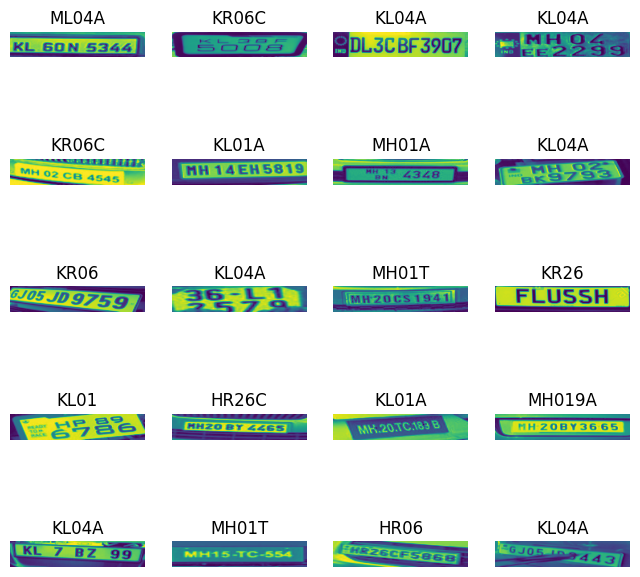

Character Accuracy: 18.64
Word Accuracy: 0.00


In [14]:
args['imgdir'] = 'test_images'
args['data'] = CarPlatesDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')